In [1]:
# from IPython.core.display import display,HTML
# display(HTML('<style> div.prompt {display:default} </style>'))

In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import linalg, stats, ndimage, io
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':13})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
import ladyns as ldn
import ladyns.inference as inf
import ladyns.optimize.core as core

In [5]:
importlib.reload(ldn)
importlib.reload(inf)
importlib.reload(core)

<module 'ladyns.optimize.core' from '/home/hbong/miniconda3/lib/python3.7/site-packages/ladyns/optimize/core.cpython-37m-x86_64-linux-gnu.so'>

# 0. load data

In [8]:
save_dir = "../temp"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [9]:
data_dir = "../data"
file_name = ['lfp_bred_1.mat', 'lfp_bred_2.mat', 'lfp_bred_3.mat']
rec_time = [0, 0.5]

In [10]:
data = [
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['v4_bred']
                    for fname in file_name], 0)[:,:,:100:2].T,
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['pfc_bred']
                    for fname in file_name], 0)[:,:,:100:2].T]

In [11]:
data[0].shape, data[1].shape

((50, 25, 3000), (50, 25, 3000))

In [12]:
dims = [data[0].shape[1], data[1].shape[1]]
num_time = data[0].shape[0]
obs_trial = data[0].shape[2]

## load LaDynS run on data

In [13]:
result_exp = np.load('result_exp.npz')
Sigma_exp = result_exp['Sigma_est']
weight_exp = result_exp['weight_est']

## cross precision

In [14]:
num_blobs = 3

In [15]:
times = np.array([[1, 1, 12], [21, 18, 6], [32, 37, 9]])

In [16]:
H0 = np.zeros((times.shape[0], num_time, num_time))
for i, (time_0, time_1, duration) in enumerate(times):
    H0[i, time_0:time_0+duration, time_1:time_1+duration] \
    = np.abs(np.arange(duration)-np.arange(duration)[:,None]) < 2

(0.0, 1.0, 0.0, 1.0)

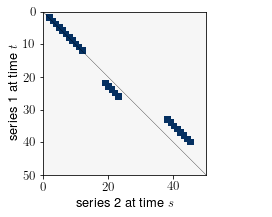

In [17]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(4,3))
gridspec.GridSpec(1,4); plt.subplot2grid((1,4), (0,0), colspan=3, rowspan=1)
ldn.imshow(np.sum(H0, 0), time=[0,50], identity=True, vmax=1)
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
ax = plt.subplot2grid((1,4), (0,3))
ax.axis('off')

## latent direction

In [23]:
mu = [np.mean(dat, -1) for dat in data]
covs = [
    np.matmul(dat - m[...,None], dat - m[...,None], axes=[(1,2),(2,1),(1,2)])/obs_trial
    for dat, m in zip(data, mu)]

In [24]:
weights_exp = [np.array(weight_exp[:num_time]),
               np.array(weight_exp[num_time:])]
betas_exp = [(cov @ w[...,None])[...,0] for cov ,w in zip(covs, weights_exp)]

## latent precision

In [25]:
sighat = Sigma_exp.copy()
sighat_1 = sighat[:num_time,:num_time]
sighat_2 = sighat[num_time:,num_time:]

In [26]:
Y_mm_1 = np.concatenate([[0], np.cumsum(np.sqrt(-2*np.log(
    sighat_1[np.arange(1,num_time), np.arange(0,num_time-1)])))])
Y_mm_2 = np.concatenate([[0], np.cumsum(np.sqrt(-2*np.log(
    sighat_2[np.arange(1,num_time), np.arange(0,num_time-1)])))])

In [27]:
sigmm_1 = np.exp(-(np.square(Y_mm_1[:,None] - Y_mm_1[None,:])/2))
sigmm_2 = np.exp(-(np.square(Y_mm_2[:,None] - Y_mm_2[None,:])/2))

In [28]:
precs_auto = [linalg.inv(S + 0.5 * np.eye(num_time))
              for S in [sigmm_1, sigmm_2]] 

## simulation function

In [31]:
def generate_param(snr):
    prec_latent = np.array(np.block([
        [precs_auto[0], -snr*np.sum(H0,0)],
        [-snr*np.sum(H0,0).T, precs_auto[1]]
    ]))
    cov_latent = linalg.inv(prec_latent)
    cov_latent = cov_latent + np.real(np.min(linalg.eig(Sigma_exp)[0]) - np.min(linalg.eig(cov_latent)[0]))*np.eye(2*num_time)
    sd_latent = np.sqrt(np.diag(cov_latent))
    corr_latent = cov_latent / sd_latent / sd_latent[:,None]
    chol_latent = linalg.cholesky(corr_latent)
    
    return chol_latent

In [32]:
def generate_sim(num_trial, data, chol_latent):
    obs_trial = data[0].shape[2]
    
    dummy = [dat[:,:,np.random.choice(obs_trial, num_trial, replace=False)]
             for dat, dim in zip(data, dims)]
    ldummy = [np.squeeze(np.matmul(dir_i[:,None,:], dumm - np.mean(dumm, -1, keepdims=True)))
              for dir_i, dumm in zip(weights_exp, dummy)]

    # cov_ldummy = np.cov(ldummy[0], ldummy[1])
    # sd_ldummy = np.sqrt(np.diag(cov_ldummy))

    latent_variables = (chol_latent.T @ np.random.normal(0, 1, (2*num_time, num_trial)))

    pops = [dummy[0] + betas_exp[0][:,:,None] * (latent_variables[:num_time,None,:]-ldummy[0][:,None,:]),
            dummy[1] + betas_exp[1][:,:,None] * (latent_variables[num_time:,None,:]-ldummy[1][:,None,:])]
        
    return pops

# 1. simulation

## preliminary parameters

In [36]:
offset_cross=10
offset_auto=10
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.zeros(11), ## lambdas_auto
    np.full((11,), 0.5), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [37]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

In [39]:
snrs = np.array([0.002, 0.004, 0.006, 0.008, 0.010])

## iterate simulation

In [40]:
num_cv = 10
num_sim = 60
num_bst = 200
num_trial = 3000

In [ ]:
for iter_sim in range(num_sim):
    for iter_snr, snr in enumerate(snrs):   
        if os.path.exists("%s/result_sim_%.1d_%.3d.npz"%(save_dir, iter_snr, iter_sim)):
            continue
        
        while True:
            with np.errstate(all='raise'):
                try:
                    start_sim = time.time()

                    # data simulation
                    chol_latent = generate_param(snr)
                    pops = generate_sim(num_trial, data, chol_latent)

                    # choosing tuning parameter
                    Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
                    weights_cv = []
                    for iter_cv in np.arange(num_cv):
                        start_cv = time.time()

                        # random sample
                        trial_sample = np.random.choice(num_trial, num_trial, False)
                        pops_bst = [pops[0], pops[1][:,:,trial_sample]]

                        # estimate for each parameter set
                        for iter_lambda, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
                        in enumerate(zip(*lambdas)): 
                            if iter_cv > 0:
                                init_arg = {'Omega_init': Omegas_cv[0,iter_lambda],
                                            'weight_init': weights_cv[iter_lambda]}
                            elif iter_lambda > 0:
                                init_arg = {'Omega_init': Omegas_cv[0,iter_lambda-1],
                                            'weight_init': weights_cv[iter_lambda-1]}
                            else:
                                init_arg = dict()
                                
                            Omega_lambda, Sigma_lambda, latent_lambda, weight_lambda \
                            = ldn.fit(pops_bst, lambda_diag, lambda_cross, offset_cross,
                                       lambda_auto, offset_auto, ths_glasso=1e-6, ths_lasso=1e-6,
                                       **init_arg)

                            # save result
                            Omegas_cv[iter_cv, iter_lambda] = Omega_lambda
                            if iter_cv == 0:
                                weights_cv.append(weight_lambda)

                        sys.__stdout__.write("%d-%d-%d-th cv finished, lapse: %.3fsec.\n"
                                             %(iter_snr+1, iter_sim+1, iter_cv+1, time.time()-start_cv))
                        sys.__stdout__.flush()
                
                except FloatingPointError:
                    sys.__stdout__.write("%d-%d-%d-th cv encountered FloatingPointError, lapse:%.3fsec.\n"
                                         %(iter_snr+1, iter_sim+1, iter_cv+1, time.time()-start_cv))
                    sys.__stdout__.write("Retrying...\n")
                    sys.__stdout__.flush()
                    continue
                
                sys.__stdout__.write("%d-%d-th simulation cv finished, lapse:%.3fsec.\n"
                                     %(iter_snr+1, iter_sim+1, time.time()-start_sim))
                sys.__stdout__.flush()
                break
                     
        # result tuning parameter
        fdrs_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/np.sum(time_graph_cross)/num_cv
        id_cv = np.argmax(fdrs_cv[fdrs_cv < 0.05])
        lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[id_cv]
        
        # original estimation
        start_est = time.time()
        
        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(pops, lambda_diag, lambda_cross, offset_cross,
                  lambda_auto, offset_auto, ths_glasso=1e-6, ths_lasso=1e-6)
        
        sys.__stdout__.write("%d-%d-th estimation finished, lapse: %.3fsec.\n"
                             %(iter_snr+1, iter_sim+1, time.time()-start_est))
        sys.__stdout__.flush()
        
        # permutation test
        Omegas_bst = np.zeros([num_bst, 2*num_time, 2*num_time])
        Sigmas_bst = np.zeros([num_bst, 2*num_time, 2*num_time])
        
        init_arg = {'Omega_init': Omegas_cv[0,id_cv],
                    'weight_init': weights_cv[id_cv]}
        for iter_bst in range(num_bst):
            while True:
                with np.errstate(all='raise'):
                    try:
                        start_bst = time.time()

                        # random sample
                        trial_sample = np.random.choice(num_trial, num_trial, True)
                        pops_bst = [pops[0], pops[1][:,:,trial_sample]]

                        # bootstrap
                        Omega_bst, Sigma_bst, latent_bst, weight_bst \
                        = ldn.fit(pops_bst, lambda_diag, lambda_cross, offset_cross,
                                  lambda_auto, offset_auto, ths_glasso=1e-6, ths_lasso=1e-6,
                                  **init_arg)
                        
                    except FloatingPointError:
                        sys.__stdout__.write("%d-%d-%d-th bootstrap encountered FloatingPointError, lapse:%.3fsec.\n"
                                             %(iter_snr+1, iter_sim+1, iter_bst+1, time.time()-start_bst))
                        sys.__stdout__.write("Retrying...\n")
                        sys.__stdout__.flush()
                        continue

                    # save result
                    Omegas_bst[iter_bst] = Omega_bst
                    Sigmas_bst[iter_bst] = Sigma_bst

                    sys.__stdout__.write("%d-%d-%d-th bootstrap finished, lapse: %.3fsec.\n"
                                  %(iter_snr+1, iter_sim+1, iter_bst+1, time.time()-start_bst))
                    sys.__stdout__.flush()
                    break
        
        np.savez("%s/result_sim_%.1d_%.3d"%(save_dir, iter_snr, iter_sim),
                 Omega_est=Omega_est, Sigma_est=Sigma_est,
                 Omegas_perm=Omegas_bst, Sigmas_perm=Sigmas_bst)

        sys.__stdout__.write("%d-th simulation finished, lapse: %.3fsec.\n"
                              %(iter_sim+1, time.time()-start_sim))
        sys.__stdout__.flush()  